# Aplicare KMeans & Fuzzy C-Means pe imagine in diverse spatii de culoare

INSTALARE PACHETE OpenCV si FCM (daca este cazul)
- se ruleaza din - Anaconda Prompt - comenzile:

    `pip install opencv-contrib-python`
    
    `pip install fuzzy-c-means`

In [1]:
# Import librarii necesare aplicatie

from sklearn.cluster import KMeans
from fcmeans import FCM
#from fcmeans_loc import FCM

import os
import numpy as np
import cv2 
import matplotlib.pyplot as plt

# Import functii din fisier ColorSpaceFunctions.py 
# (acest fisier trebuie sa fie disponibil in directorul ../_PyUtilFcts)
import sys
sys.path.append('../_PyUtilFcts/')
import ColorSpaceFunctions as clsFcts


In [2]:
# Functie pentru a citi si afisa imaginea dintr-un fisier 
def CitireAfisareImagine(imgFile):
    print('\n   ----- INFO - Imaginea selectata -----\n')      
    print("Imaginea originala, din fisierul :", imgFile)

    imgBGR = cv2.imread(imgFile) 
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB) 
    print("         Shape:" , imgRGB.shape,", Type :" , imgRGB.dtype)
    fig = plt.figure(figsize=(10,10)); plt.imshow(imgRGB); plt.show()
    return imgRGB

In [3]:
def ConversieAfisareImgColorSpace(imgRGB, SelClrSp):
    NewClrSp = ColorSpacesList[SelClrSp] 
    OrgClrSp = ColorSpacesList[0] # 0 - pentru RGB - imaginea la deschidere este RGB
    print('\n  ----- INFO - In[2] Conversie Spatiu de Culoare, din ' + OrgClrSp + ' in '+ NewClrSp)
    ImgClrSp = clsFcts.ConvertColorSpace(imgRGB, OrgClrSp , NewClrSp)

    clsFcts.plotColorComponents(ImgClrSp, NewClrSp)
    clsFcts.plotColorHistograms(ImgClrSp, NewClrSp)
    clsFcts.plot3DcolorSpace(ImgClrSp, imgRGB, NewClrSp)
    return ImgClrSp

In [4]:
# In[3] - Aplicare KMeans & Fuzzy C-Means pe imagine 
def AplicareKMeansFuzzyCMeans(ImgClrSp, imgRGB, imgComps, nr_clusters):
    print('\n [Info]  - Aplicare Segmentare KMeans & Fuzzy C-Means')

    # Pregatirea setului de datelor - toti pixelii din imagine 
    # se considera vectorul de trasaturi pentru descrierea fiecarui pixel 
    #       in functie de spatiu de culoare selectat si componetele alese 
    OrgColorSpace = ColorSpacesList[0] # 0 - pentru RGB - imaginea la deschidere este RGB
    NewColorSpace = ColorSpacesList[SelClrSp] 
    
    # extragerea denumirii componentelor selectate pentru procesare (scop = afisare)
    compSelected = []
    for index in range(imgComps.shape[0]):  
        compSelected.append (NewColorSpace.split('/')[imgComps[index]])
    print('\t Consideram fiecare pixel descris prin componetele ', compSelected);
    print('\t Clasificare/grupare valori in ', nr_clusters,  ' clase');
    imgSize = imgRGB.shape

    # Extragem doar componentele dorite pentru descrierea culorii
    # Se redimensioneaza imformatia ca un vector de 2D, unde pe linii avem datele/pixelii
    #       iar pe coloane descrierea fiecarui pixel - vectorul de trasaturi
    colorData = np.reshape(ImgClrSp[:,:, imgComps], (imgSize[0]*imgSize[1], imgComps.shape[0]) ) 

    # --------- Aplicare KMeans
    kmeans = KMeans(nr_clusters)
    kmeans.fit(colorData)

    # Outputs: extragerea centrelor claselor si 
    #       a label-urilor dupa segmentare pentru fiecare pixel
    km_centers = kmeans.cluster_centers_
    km_labels = kmeans.labels_

    # Asocierea label-urilor pixelilor cu valoarea centrului clasei 
    ImgRefCompKM = km_centers[km_labels] 

    # --------- Aplicare Fuzzy C-Means
    fcm = FCM(n_clusters=nr_clusters)
    fcm.fit(colorData)

    # Outputs
    fcm_centers = fcm.centers
    fcm_labels  = fcm.u.argmax(axis=1)

    # Asocierea label-urilor pixelilor cu valoarea centrului clasei 
    ImgRefCompFcm = fcm_centers[fcm_labels] 

    # Ne generam o imagine (goala) care are toate valorile constante pe toate componentele
    ImgSegKMeans = np.zeros(ImgClrSp.shape, dtype = 'uint8') + 128
    ImgSegFcm = np.zeros(ImgClrSp.shape, dtype = 'uint8') + 128
    # Modificam valorile de pe componentele procesate cu valoarea centrelor claselor
    ImgSegKMeans[:,:,imgComps]=  np.reshape(ImgRefCompKM, (imgSize[0],imgSize[1], imgComps.shape[0]) )
    ImgSegFcm[:,:,imgComps]=  np.reshape(ImgRefCompFcm, (imgSize[0],imgSize[1], imgComps.shape[0]) )
    # Conversie imagine din statiu de culoare folosit in procesare in spatiu RGB (pentru afisare)
    ImgSegKMeansRGB = clsFcts.ConvertColorSpace(ImgSegKMeans, NewColorSpace , OrgColorSpace)
    ImgSegFcmRGB = clsFcts.ConvertColorSpace(ImgSegFcm, NewColorSpace , OrgColorSpace)


    #%% Afisare rezultat 
    # Afisarea imaginilor dupa segmentare
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(20,6))
    ax1.imshow(ImgSegKMeansRGB ); ax1.set_title('KMeans'); 
    ax2.imshow(ImgSegFcmRGB); ax2.set_title('Fuzzy C-Means'); 
    plt.show

    #%% Afisare plot (doar pentru cazul 1D si 2D)
    # Pentru afisare in plot, culorile trebuie sa fie valori in [0, 1] 
    clrCodKMeans = np.reshape(ImgSegKMeansRGB, (imgSize[0]*imgSize[1], 3) )/255;
    clrCodFcm = np.reshape(ImgSegFcmRGB, (imgSize[0]*imgSize[1], 3) )/255;
    clrCodOrg = np.reshape(imgRGB, (imgSize[0]*imgSize[1], 3) )/255;
    nrVals = colorData.shape[0]; pas = int(nrVals/1000)+1; valsRange = range(0, nrVals, pas);

    # Stabilire componente ca si pozitie din imgComps 
    #   pentru plot pe axa X si Y
    xc = 0; yc = 1
    if  (imgComps.shape[0] == 1): # atunci axa X si Y reprezinta aceeasi componenta
        xc = 0; yc = 0
    if  (imgComps.shape[0] < 3):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(20,6))
        ax1.set_title('K Means')
        ax1.scatter(colorData[valsRange,xc],colorData[valsRange,yc],c=clrCodKMeans[valsRange], marker='.')
        ax1.scatter(km_centers[:,xc], km_centers[:,yc], marker='o', c='blue')
        ax1.set_xlabel(compSelected[xc]); ax1.set_ylabel(compSelected[yc]);
        ax2.set_title("Fuzzy C-Means")
        ax2.scatter(colorData[valsRange,xc],colorData[valsRange,yc],c=clrCodFcm[valsRange], marker='.')
        ax2.scatter(fcm_centers[:,xc], fcm_centers[:,yc], marker='o', c='red')
        ax2.set_xlabel(compSelected[xc]); ax2.set_ylabel(compSelected[yc]);
        ax3.set_title("Original")
        ax3.scatter(colorData[valsRange,xc],colorData[valsRange,yc],c=clrCodOrg[valsRange], marker='.')
        ax3.scatter(km_centers[:,xc], km_centers[:,yc], marker='o', c='blue')
        ax3.scatter(fcm_centers[:,xc], fcm_centers[:,yc], marker='o', c='red')
        ax3.set_xlabel(compSelected[xc]); ax3.set_ylabel(compSelected[yc]);
        plt.show

    # Afisare cub spatiu de culoare cu centrele claselor
    clsFcts.plot3DcolorSpace(ImgSegFcm, ImgSegFcmRGB, NewColorSpace)


   ----- INFO - Imaginea selectata -----

Imaginea originala, din fisierul : /Users/galoscar07/Documents/master2k20-2k22/2nd Semester/SIAI/Laborator/_TestImages/ImgTstSegmGen/rose021.jpg
         Shape: (448, 617, 3) , Type : uint8


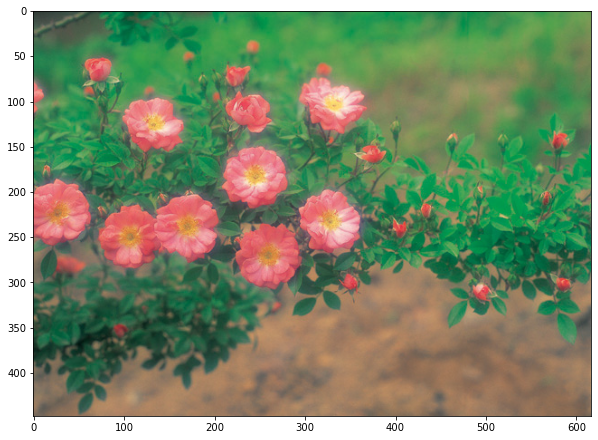


  ----- INFO - In[2] Conversie Spatiu de Culoare, din R/G/B in Y/Cr/Cb


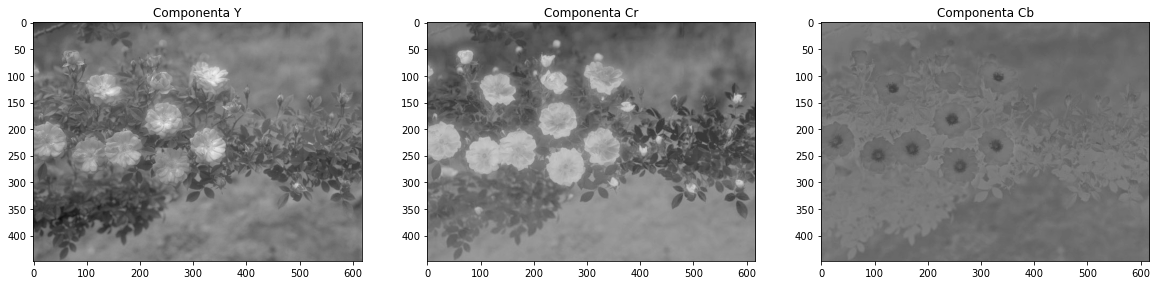

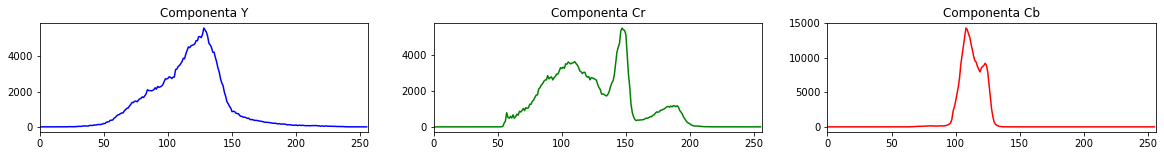


 Afisare Cub Culori in spatiu de culoare:  Y/Cr/Cb

 Numar culori unice care apar in imagine:  84656 din 2^24( 16777216 ) ; procent:  0.5 % acoperire cub


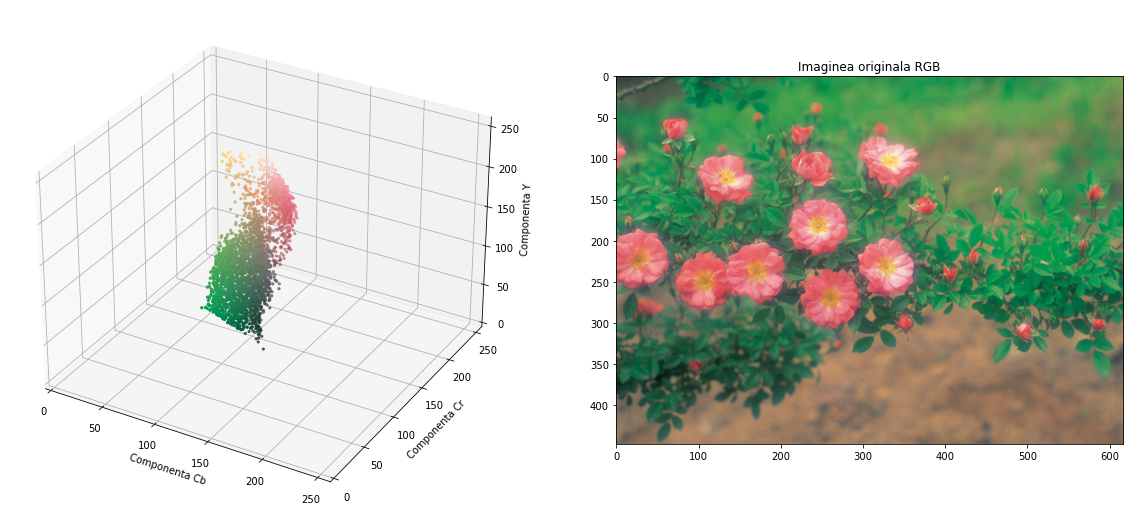


 [Info]  - Aplicare Segmentare KMeans & Fuzzy C-Means
	 Consideram fiecare pixel descris prin componetele  ['Cr', 'Cb']
	 Clasificare/grupare valori in  3  clase



 Afisare Cub Culori in spatiu de culoare:  Y/Cr/Cb

 Numar culori unice care apar in imagine:  3 din 2^24( 16777216 ) ; procent:  0.0 % acoperire cub


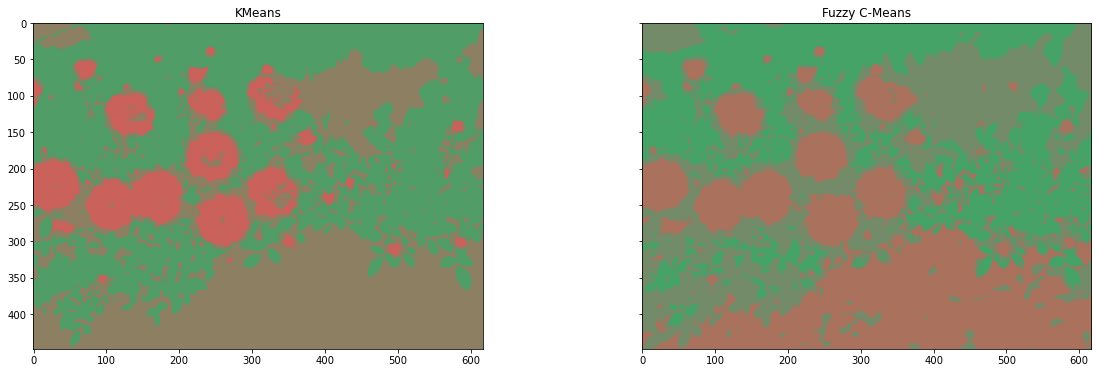

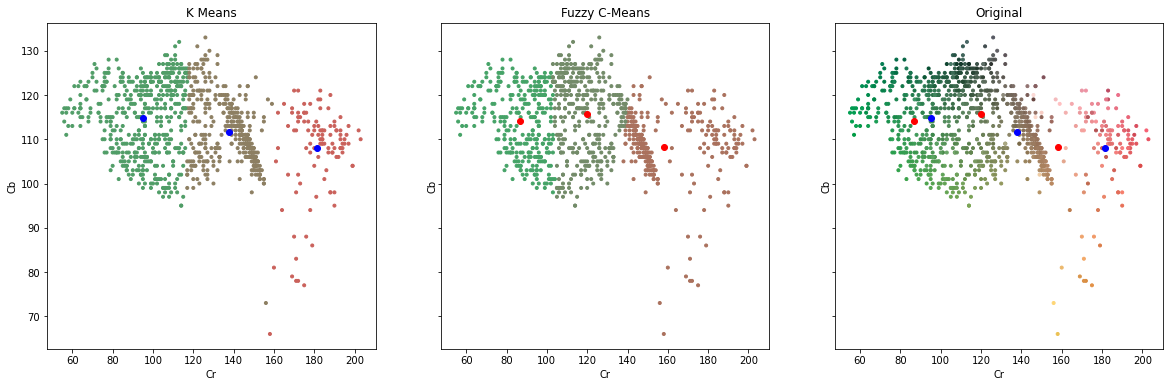

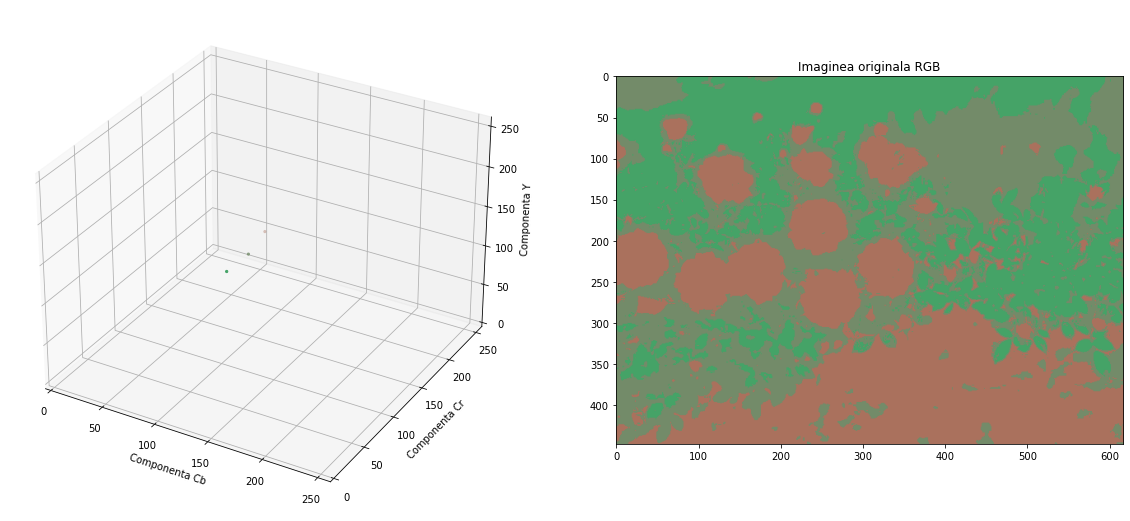

In [5]:
# Selectare imagine pe care testam aplicatia
# Se recomanda sa se pastreze imgsPath = "D:/_TestImages" - fiind directorul 
#       principal care contine subdirectoarele cu imaginile sugerate
# La setare imgName se specifica si subdirectorul din care dace parte imaginea
imgsPath = "/Users/galoscar07/Documents/master2k20-2k22/2nd Semester/SIAI/Laborator/_TestImages"
imgName = 'ImgTstSegmGen/rose021.jpg' # atentie sa fie scris corect numele imaginii!!!!
imgFile = os.path.sep.join([imgsPath, imgName])
#imgName = 'Kodak/kodim23.png'
# Sugestie imagini pentru testare (dir/ imgs):
#  ImgTstSegmGen: kronenburg-rose-closeup.jpg; roses.jpg; rose021.jpg
#  ImgTstSegmFaciale: la alegere 5 imagini - scop: segmentare zona piele intr-o singura clasa
#  ImgTstSegmBoard:   board3.bmp; board7.bmp; - scop: segmentare pioni dupa culoare 

imgRGB = CitireAfisareImagine(imgFile)


ColorSpacesList = ['R/G/B', 'Y/Cr/Cb', 'H/S/V', 'L/a/b', 'gray'] 

# Selectie spatiu de culoare in care se realizeaza operatia
#   Se selecteaza ca si o pozitie din vectorul ColorSpacesList
#   ColorSpacesList = ['RGB', 'YCrCb', 'HSV', 'Lab', 'gray']
#       0 - 'RGB' (nu se alege pentru a fi spatiu in care realizam procesarea), 
#       1 - 'YCrCb',      2 - 'HSV',           3 - 'Lab'
SelClrSp = 1 # se selecteaza ca si o pozitie din vectorul ColorSpacesList

ImgClrSp = ConversieAfisareImgColorSpace(imgRGB, SelClrSp)

# Selectie componenta pentru procesare 
#       se specifica numarul componentelor care se considera in procesare 
#       - pentru procesare 3D, toate cele 3 componente: [0, 1, 2]
# exemplu: YCbCr - [1, 2] se proceseaza doar componentele Cb, Cr; 
#          YCbCr - [0, 2] se proceseaza doar componentele Y, Cr; 
imgComps = np.array([1,2])

# Atentie: componenta Y, V sau L - sunt componente de luminta 
#  (tineti cont de acest aspect la selectie componente in functie de scopul urmarit) 

# Selectati numarul de clase/clusters
nr_clusters = 3

AplicareKMeansFuzzyCMeans(ImgClrSp, imgRGB, imgComps, nr_clusters)


   ----- INFO - Imaginea selectata -----

Imaginea originala, din fisierul : /Users/galoscar07/Documents/master2k20-2k22/2nd Semester/SIAI/Laborator/_TestImages/ImgTstSegmBoard/board4.bmp
         Shape: (210, 314, 3) , Type : uint8


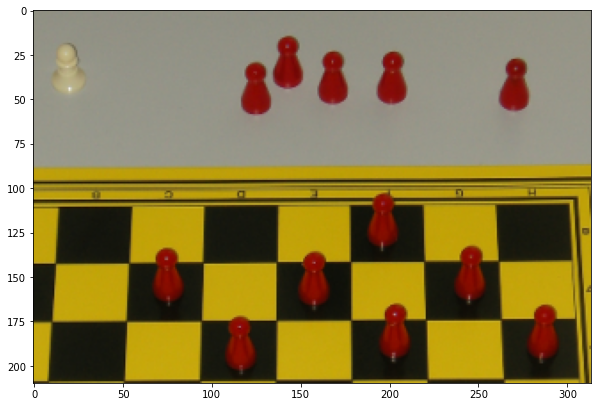


  ----- INFO - In[2] Conversie Spatiu de Culoare, din R/G/B in H/S/V


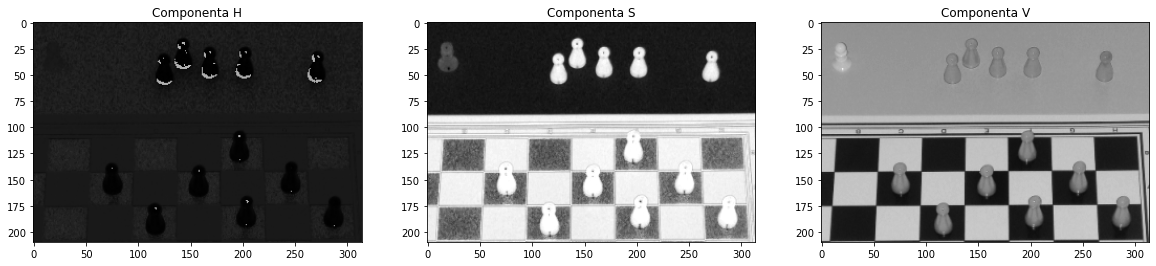

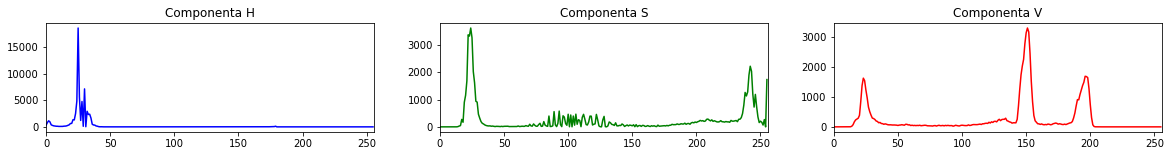


 Afisare Cub Culori in spatiu de culoare:  H/S/V

 Numar culori unice care apar in imagine:  13388 din 2^24( 16777216 ) ; procent:  0.08 % acoperire cub


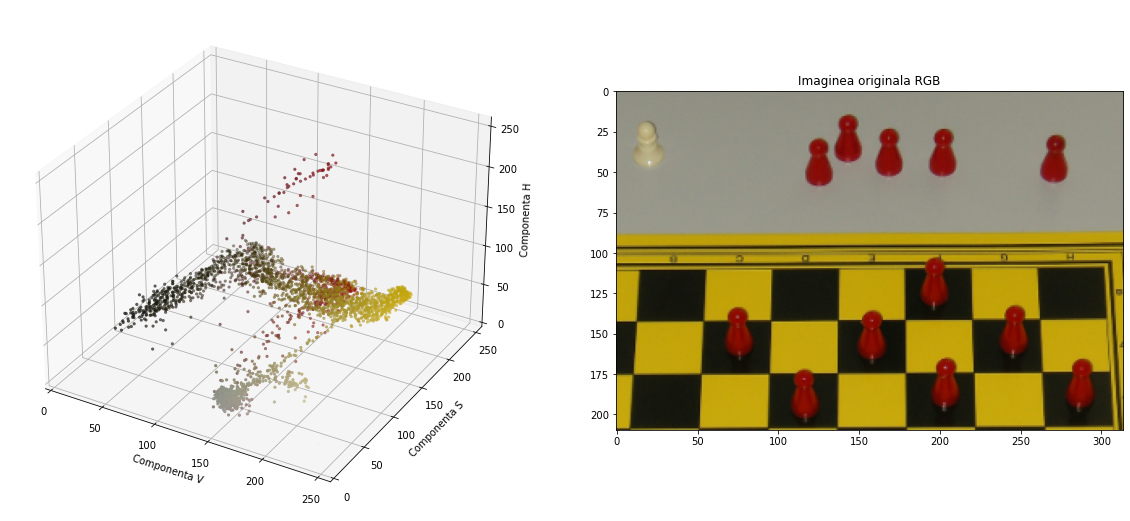


 [Info]  - Aplicare Segmentare KMeans & Fuzzy C-Means
	 Consideram fiecare pixel descris prin componetele  ['H', 'V']
	 Clasificare/grupare valori in  3  clase

 Afisare Cub Culori in spatiu de culoare:  H/S/V

 Numar culori unice care apar in imagine:  3 din 2^24( 16777216 ) ; procent:  0.0 % acoperire cub


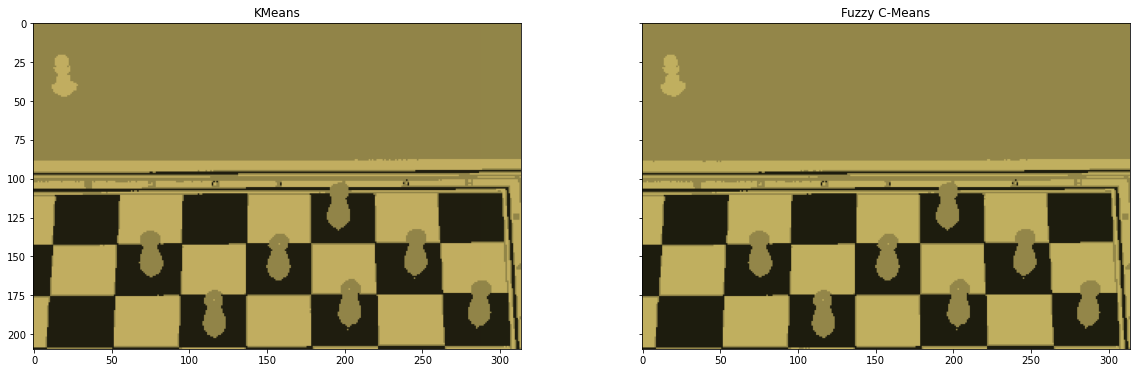

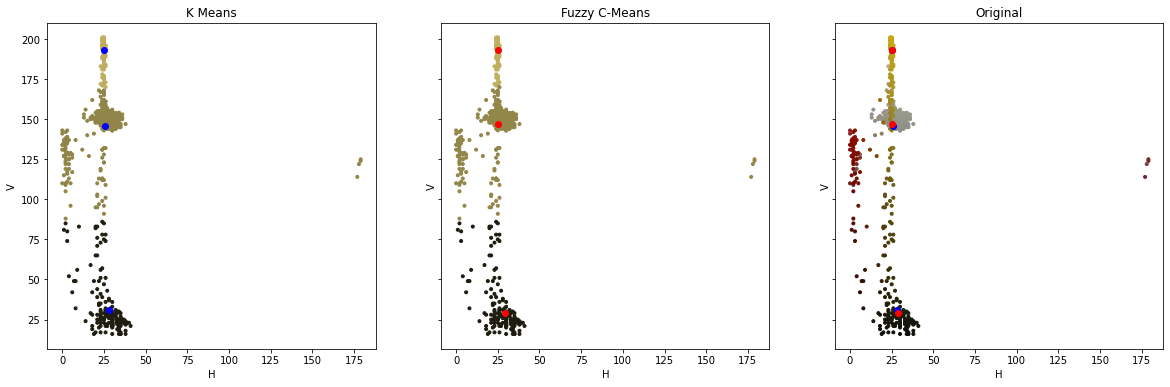

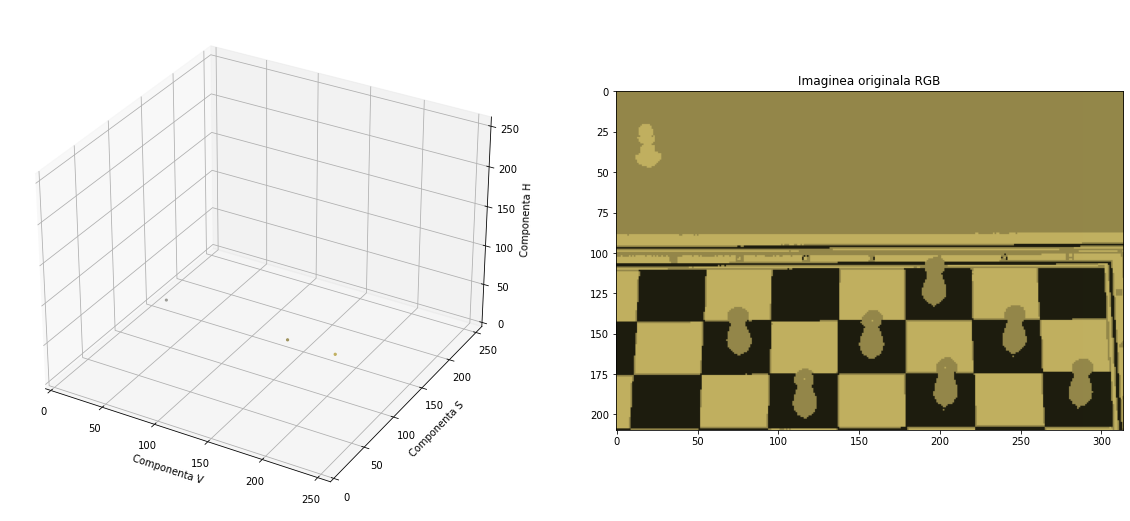

In [11]:
# Selectare imagine pe care testam aplicatia
# Se recomanda sa se pastreze imgsPath = "D:/_TestImages" - fiind directorul 
#       principal care contine subdirectoarele cu imaginile sugerate
# La setare imgName se specifica si subdirectorul din care dace parte imaginea
imgsPath = "/Users/galoscar07/Documents/master2k20-2k22/2nd Semester/SIAI/Laborator/_TestImages"
imgName = 'ImgTstSegmBoard/board4.bmp' # atentie sa fie scris corect numele imaginii!!!!
imgFile = os.path.sep.join([imgsPath, imgName])
#imgName = 'Kodak/kodim23.png'
# Sugestie imagini pentru testare (dir/ imgs):
#  ImgTstSegmGen: kronenburg-rose-closeup.jpg; roses.jpg; rose021.jpg
#  ImgTstSegmFaciale: la alegere 5 imagini - scop: segmentare zona piele intr-o singura clasa
#  ImgTstSegmBoard:   board3.bmp; board7.bmp; - scop: segmentare pioni dupa culoare 

imgRGB = CitireAfisareImagine(imgFile)


ColorSpacesList = ['R/G/B', 'Y/Cr/Cb', 'H/S/V', 'L/a/b', 'gray'] 

# Selectie spatiu de culoare in care se realizeaza operatia
#   Se selecteaza ca si o pozitie din vectorul ColorSpacesList
#   ColorSpacesList = ['RGB', 'YCrCb', 'HSV', 'Lab', 'gray']
#       0 - 'RGB' (nu se alege pentru a fi spatiu in care realizam procesarea), 
#       1 - 'YCrCb',      2 - 'HSV',           3 - 'Lab'
SelClrSp = 2 # se selecteaza ca si o pozitie din vectorul ColorSpacesList

ImgClrSp = ConversieAfisareImgColorSpace(imgRGB, SelClrSp)

# Selectie componenta pentru procesare 
#       se specifica numarul componentelor care se considera in procesare 
#       - pentru procesare 3D, toate cele 3 componente: [0, 1, 2]
# exemplu: YCbCr - [1, 2] se proceseaza doar componentele Cb, Cr; 
#          YCbCr - [0, 2] se proceseaza doar componentele Y, Cr; 
imgComps = np.array([0,2])

# Atentie: componenta Y, V sau L - sunt componente de luminta 
#  (tineti cont de acest aspect la selectie componente in functie de scopul urmarit) 

# Selectati numarul de clase/clusters
nr_clusters = 3

AplicareKMeansFuzzyCMeans(ImgClrSp, imgRGB, imgComps, nr_clusters)